# Exploration 7
## 인물 모드 문제점 찾기
---

### 목차
- Step 1. 인물 모드 직접 해 보기
- Step 2. 사진에서 문제점 찾기
- Step 3. 해결 방법을 제안해 보기
- Step 4. 해결방안 직접 구현해보기
---

## Step 0. Import

In [1]:
import os
import urllib # 웝에서 데이터를 다운로드할 때 사용
import cv2 # 이미지를 처리할 때 사용
import numpy as np
from pixellib.semantic import semantic_segmentation # 시맨틱 세그멘테이션을 할 때 사용
from matplotlib import pyplot as plt

## Step 1. 인물모드 직접 해 보기

### Load image  
이미지는 3장 준비
- 사람 이미지 
- 동물(고양이)이미지
- 장난감 이미지

(2316, 3088, 3)


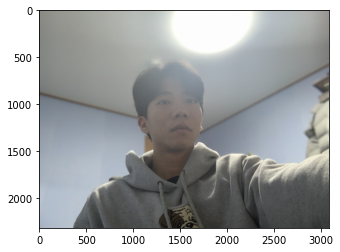

(420, 630, 3)


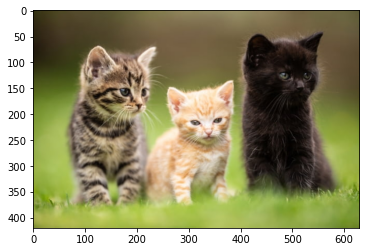

(547, 820, 3)


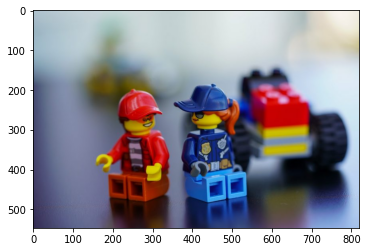

In [2]:
img_names = ['person_img', 'cat_img', 'rego_img'] # 이미지 이름 
img_origs = [] # 원본이미지

for i, img_name in enumerate(img_names):
    img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/{img_name}.jpg'  
    img_orig = cv2.imread(img_path) 
    img_origs.append(img_orig)

for i, img_orig in enumerate(img_origs):
    print(img_orig.shape)
    plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
    plt.show()

### 모델 준비
모델
- DeepLabv3+

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

# 모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

### 모델에 이미지 입력

In [4]:
img_segval_output = [] # 모델을 통해 나온 정보 저장

for i, img_name in enumerate(img_names):
    img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/{img_name}.jpg' 
    segvalues, output = model.segmentAsPascalvoc(img_path)
    img_segval_output.append((segvalues, output))
    


### output 확인

In [5]:
# 라벨 dictionary 선언
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

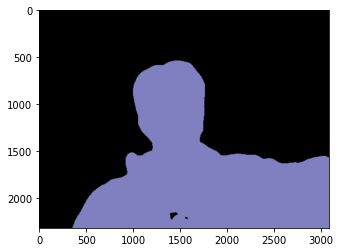

class ids: [ 0 15]
label names:  background
label names:  person


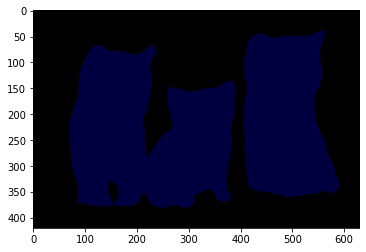

class ids: [0 8]
label names:  background
label names:  cat


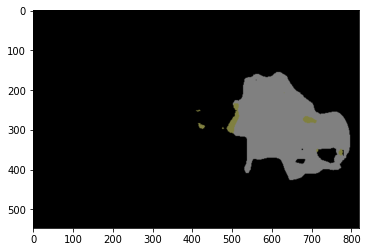

class ids: [ 0  7 14]
label names:  background
label names:  car
label names:  motorbike


In [6]:
img_class_ids = [] # 이미지 class_ids 리스트

for i, (segval, output) in enumerate(img_segval_output):
    plt.imshow(output) # output 
    plt.show()
    
    img_class_ids.append(segval['class_ids'])
    
    print('class ids:',segval['class_ids'])
    for class_id in segval['class_ids']:
        print('label names: ', LABEL_NAMES[class_id])

### background blur

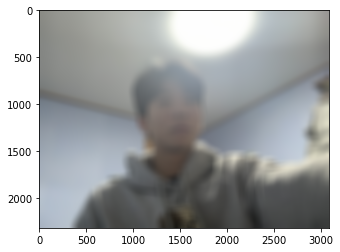

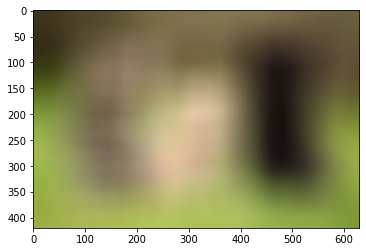

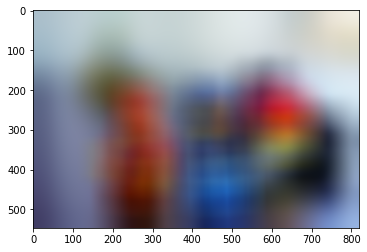

In [7]:
img_orig_blurs = []

for i, img_orig in enumerate(img_origs):
    img_orig_blur = cv2.blur(img_orig, (100,100))  # 커널 사이즈가 커질수록 blur가 더욱 진하게 바뀜
    img_orig_blurs.append(img_orig_blur)
    
    plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
    plt.show()

### images mask
- 각 이미지 class_id에서 배경이 아닌 class_id 추출
- colormap을 통해 색상 정보 추출
- 색상 정보와 output을 비교해 segmap생성
- segmap을 반전시켜 mask 생성

In [8]:
# colormap 만들기
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

label names:  person
[192 128 128]
(128, 128, 192)
(2316, 3088)


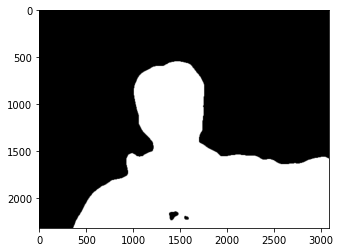

label names:  cat
[64  0  0]
(0, 0, 64)
(420, 630)


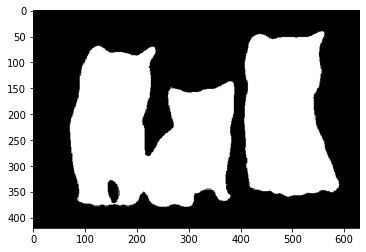

label names:  car
[128 128 128]
(128, 128, 128)
(547, 820)


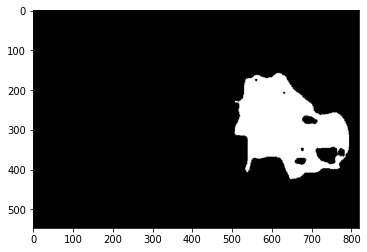

label names:  motorbike
[ 64 128 128]
(128, 128, 64)
(547, 820)


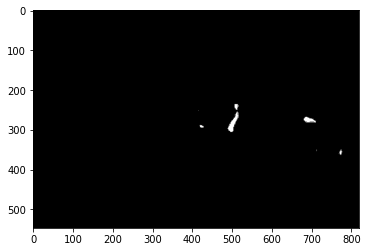

In [9]:
seg_maps = []
img_masks = []

for i, class_ids in enumerate(img_class_ids):
    for j, class_id in enumerate(class_ids):
        if class_id == 0:
            continue
        print('label names: ', LABEL_NAMES[class_id])
        print(colormap[class_id])
        
        b, g, r = colormap[class_id]
        seg_color = (r, g, b)
        print(seg_color)
        
        seg_map = np.all(img_segval_output[i][1]==seg_color, axis=-1)
        seg_maps.append(seg_map)
        
        print(seg_map.shape)
        plt.imshow(seg_map, cmap='gray')
        plt.show()
        
        img_mask = seg_map.astype(np.uint8) * 255
        img_masks.append(img_mask)

### segmentation mask 
- 이미지의 mask를 BGR로 변경
- bitwise_not()연산을 통해 배경 mask 추출
- bitwise_and()연산을 통해 블러 이미지와 합성 

In [10]:
# 블러 이미지가 3개이므로 마지막 이미지의 블러이미지 1개더 추가
img_orig_blurs.append(img_orig_blurs[2])

(2316, 3088, 3)


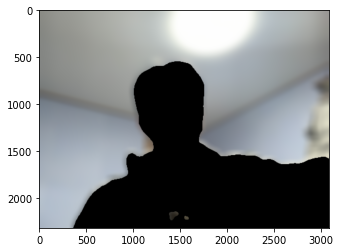

(420, 630, 3)


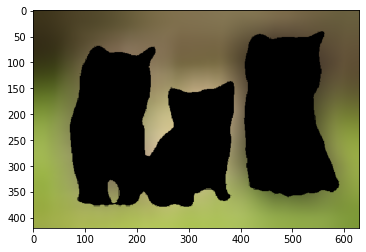

(547, 820, 3)


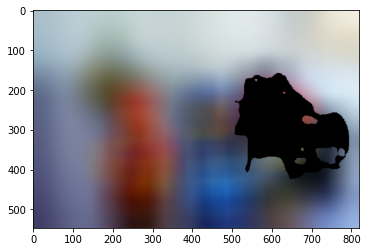

(547, 820, 3)


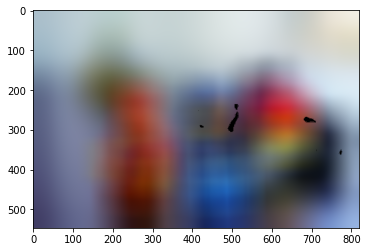

In [11]:
# 각각의 리스트 선언
img_mask_colors = []
img_bg_masks = []
img_bg_blurs = []


for i, img_mask in enumerate(img_masks):
    img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
    img_mask_colors.append(img_mask_color)
    
    img_bg_mask = cv2.bitwise_not(img_mask_color)
    img_bg_masks.append(img_bg_mask)
    
    img_bg_blur = cv2.bitwise_and(img_orig_blurs[i], img_bg_mask)
    print(img_bg_blur.shape)
    img_bg_blurs.append(img_bg_blur)
    
    plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
    plt.show()

### 흐린 배경과 원본 영상 합성
- np.where()함수로 원본이미지와 블러 이미지 합성

In [12]:
# 원본이미지가 3개이므로 마지막 이미지의 원본이미지 1개더 추가
img_origs.append(img_origs[2])

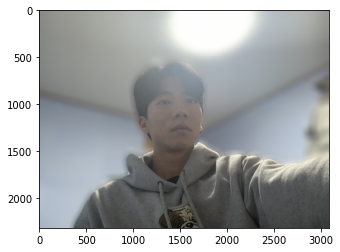

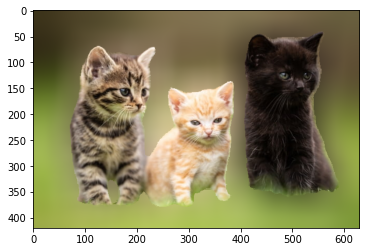

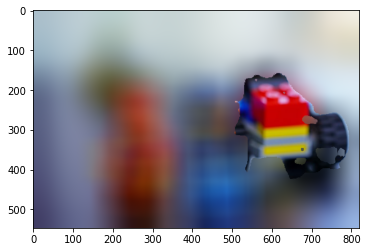

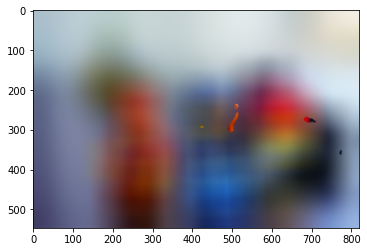

In [13]:
for i, img_orig in enumerate(img_origs):
    img_concat = np.where(img_mask_colors[i]==255, img_orig, img_bg_blurs[i])
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

### 배경을 blur가 아닌 크로마키 합성하기
- 배경이미지 불러오기
- 배경이미지를 원본이미지의 크기에 맞게 변경
- np.where()를 이용하여 이미지 합성

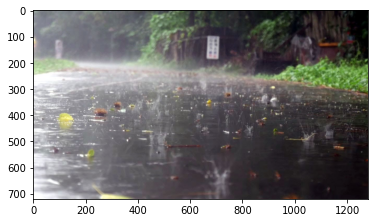

In [14]:
bg_img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/bg_img.jpg'  
bg_img = cv2.imread(bg_img_path) 

plt.imshow(cv2.cvtColor(bg_img, cv2.COLOR_BGR2RGB))
plt.show()

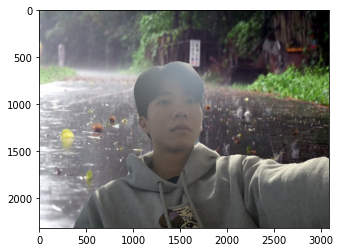

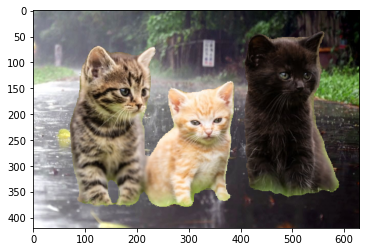

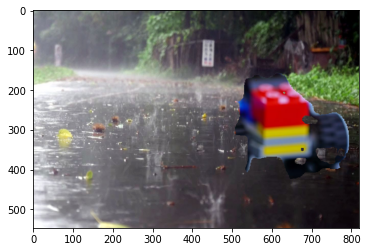

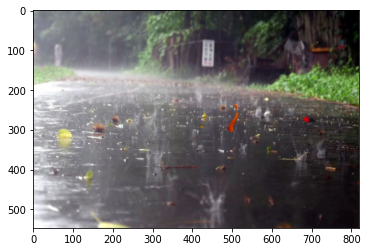

In [15]:
for i, img_orig in enumerate(img_origs):
    w, h, c = img_orig.shape
    
    bg_img_resize = cv2.resize(bg_img, dsize=(h,w), interpolation=cv2.INTER_LINEAR)
    
    img_concat = np.where(img_mask_colors[i]==255, img_orig, bg_img_resize)
    plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
    plt.show()

## Step 2. 사진에서 문제점 찾기

### 문제점 
- LABEL_NAMES의 정의되지 않은 객체는 segmentation을 할 수 없다. (레고 사진)

LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]

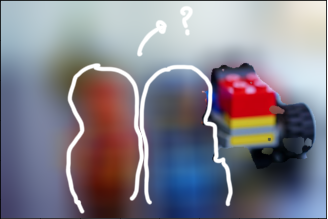

## Step 3. 해결방안을 제시해 보기

### 해결책 
- PASCAL VOC데이터 말고 다른 데이터를 사용한다.
- PASCAL VOC를 전이학습하여 다른 라벨을 추가적으로 넣는다. 밑에서 다른 모델을 적용할때 여러개의 class_id들로 pre학습한 모델을 선정하여 직접 구현하였다.

## Step 4. 해결방안 직접 구현해보기
- 다른 데이터로 학습한 모델 사용

### 다른 데이터로 학습한 모델 예시
학습 모델
- ade20k 데이터로 학습한 Xception모델    
   
과정
- 모델 다운로드
- 모델 불러오기
- 모델에 이미지를 넣고 output을 저장 이 때 원본이미지와 비교를 위해 오버레이 Ture로 변경

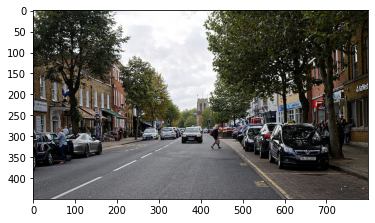

In [16]:
img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/sample1.jpg'  
sample1 = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB))
plt.show()

In [17]:
# use Xception model trained on ade20k dataset
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception65_ade20k.h5')

segment_video = semantic_segmentation()
segment_video.load_ade20k_model(model_file)
segment_video.segmentAsAde20k(img_path, output_image_name="image_new.jpg", overlay= True)

Processed Image saved successfully in your current working directory.


({'class_ids': [5, 7, 2, 3, 21, 12, 13, 117, 88],
  'class_names': ['tree',
   'road',
   'building',
   'sky',
   'car',
   'sidewalk',
   'person',
   'minibike',
   'streetlight'],
  'class_colors': [array([  4, 200,   3]),
   array([140, 140, 140]),
   array([180, 120, 120]),
   array([  6, 230, 230]),
   array([  0, 102, 200]),
   array([235, 255,   7]),
   array([150,   5,  61]),
   array([163,   0, 255]),
   array([  0,  71, 255])],
  'masks': array([[False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         ...,
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False],
         [False, False, False, ..., False, False, False]]),
  'ratios': [33.35978190104167,
   23.442247178819446,
   19.243028428819446,
   11.189100477430555,
   9.50588650173611,
   1.9809299045138888,
   0.7405598958333333,
   0.5093044704

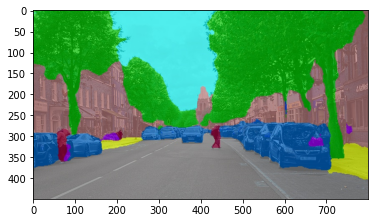

In [18]:
img_path = os.getenv('HOME')+f'/aiffel/image_new.jpg'  
sample1 = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB))
plt.show()

### 해결방안 시험

이미지 가져오기

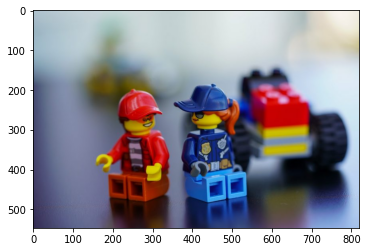

In [19]:
img_path = os.getenv('HOME')+f'/aiffel/human_segmentation/images/rego_img.jpg'  
rego_img = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(rego_img, cv2.COLOR_BGR2RGB))
plt.show()

모델 불러오기 & 모델에 이미지 넣고 segvalues, output 추출

In [20]:
# use Xception model trained on ade20k dataset
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception65_ade20k.h5')

segment_video = semantic_segmentation()
segment_video.load_ade20k_model(model_file)
segvalues, output = segment_video.segmentAsAde20k(img_path)

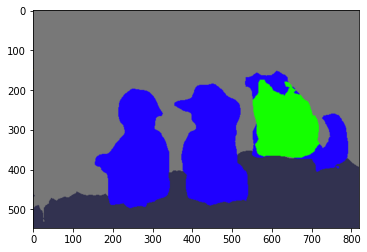

In [21]:
plt.imshow(output)
plt.show()

이미지의 segvalues(class_ids, class_names, class_color)확인

In [22]:
print(segvalues['class_ids'])
print(segvalues['class_names'])
print(segvalues['class_colors'])

[1, 4, 109, 42, 3]
['wall', 'floor', 'plaything', 'box', 'sky']
[array([120, 120, 120]), array([80, 50, 50]), array([255,   0,  31]), array([  0, 255,  20]), array([  6, 230, 230])]


이미지 segvalues의 class중 'plaything'과 'box'선택       
두 개의 seg_map구성 후 합성

(547, 820)


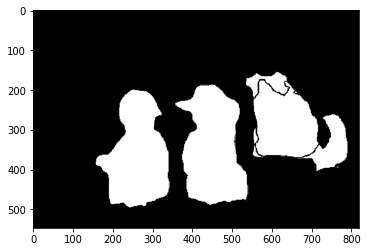

In [23]:
seg_color1 = (31, 0, 255)
seg_color2 = (20, 255, 0)
seg_map1 = np.all(output==seg_color1, axis=-1)
seg_map2 = np.all(output==seg_color2, axis=-1)

seg_map = seg_map1 + seg_map2

print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

원본이미지 곂치기

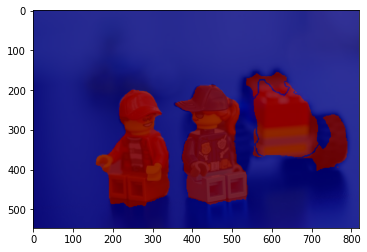

In [24]:
# 원본 이미지와 곂쳐보기
img_show = rego_img.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.2, color_mask, 0.8, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

mask 생성

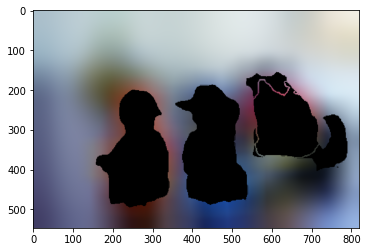

In [25]:
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

최종 합성

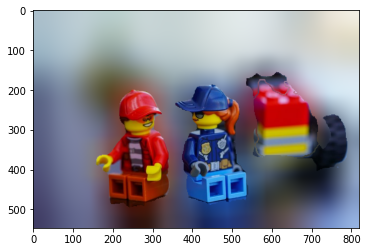

In [26]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 정리

### 프로젝트에서 어려웠던 점 
- 프로젝트는 주피터 노트북환경에서 구현하였는데 사실 동영상의 실시간 처리과정을 보고 싶어 동영상을 업로드 할려고 했으나 주피터노트북에서는 동영상을 어떻게 업로드 하는지 잘 몰라 실패하였습니다. 인터넷에 열심히 찾아봤지만 구현하지 못하였습니다.

### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한점 
- 어떤 데이터로 모델을 학습하냐에 따라 데이터의 라벨이 달라지기 때문에 상황에 맞게 학습한 모델을 골라야 한다는 것을 알아 냈습니다.

### 루브릭 평가 지표를 맞추기 위해 시도한 것들
- 다른 데이터로 학습한 모델을 가져와 이미지 합성시도
- seg_map을 여러개 만든 후 합성

### 자기다짐 
- 실생활에서는 멈춰있는 사진을 활용하는 기술도 많이 쓰이지만 실시간 영상인 비디오를 활용하는 기술이 더 많이 쓰이기 때문에 실시간에서 segmentation이 어떻게 일어나고 활용할 수 있는지 공부해야겠다고 생각했습니다.
